# Recon Cartographer
A script to transform a photo of a region sticker discovered through a recon action into a grayscale template that is convenient for printing. Different arrangements of supply lines can be experimented with by drawing on the printout ahead of making the decision within the game.

In [21]:
%matplotlib inline

import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import seaborn as sns
import skimage
import skimage.color
import skimage.data
import skimage.feature
import skimage.filters
import skimage.future
import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.transform

from google.cloud import vision
from google.cloud.vision import types

In [22]:
# first_recon.png was captured using an iPhone 7 Plus in a room illuminated with daylight. No flash.
path_im = "first_recon.png"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\karhohs\Downloads\bgb-jupyter-0eee48249fae.json"

In [23]:
im = skimage.io.imread(path_im)

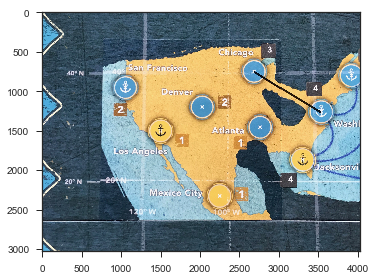

In [24]:
skimage.io.imshow(im)

In [25]:
path_im = "first_recon_scale1.png"
with io.open(path_im, 'rb') as image_file:
    content = image_file.read()
image = types.Image(content=content)

In [17]:
client = vision.ImageAnnotatorClient()

Labels:
<bound method _AddListFieldsMethod.<locals>.ListFields of mid: "/m/01l0y0"
description: "material"
score: 0.6049442291259766
topicality: 0.6049442291259766
>
<bound method _AddListFieldsMethod.<locals>.ListFields of mid: "/m/03gq5hm"
description: "font"
score: 0.5628558993339539
topicality: 0.5628558993339539
>
<bound method _AddListFieldsMethod.<locals>.ListFields of mid: "/m/06wqb"
description: "space"
score: 0.5442237854003906
topicality: 0.5442237854003906
>
<bound method _AddListFieldsMethod.<locals>.ListFields of mid: "/m/09nm_"
description: "world"
score: 0.5231351852416992
topicality: 0.5231351852416992
>
<bound method _AddListFieldsMethod.<locals>.ListFields of mid: "/m/04_tb"
description: "map"
score: 0.503383219242096
topicality: 0.503383219242096
>


In [ ]:
response = client.label_detection(image=image)
labels = response.label_annotations

print('Labels:')
for label in labels:
    print(label.ListFields)

# Color threshold
Convert the color or RGB image into HSV color format in order to threshold based upon color and brightness.
* Hue contains information about the color, such as a particular shade of blue or orange.
* Saturation contains information about how much background color there is. The highest level of saturation will give the purest color and there is no background. The lowest level of saturation will look white, because the color doesn't much stand out beyond any other color.
* Value contains information about the brightness of a color. Low values will be black and high values will be intense and bright.

The image is converted into a pandas dataframe for the convenience of plotting histograms with the seaborn python library.

In [18]:
im_hsv = skimage.color.rgb2hsv(im)

In [19]:
im_hsv_dict = {}

im_hsv_dict["hue"] = im_hsv[:,:,0].flatten()

im_hsv_dict["sat"] = im_hsv[:,:,1].flatten()

im_hsv_dict["val"] = im_hsv[:,:,2].flatten()

df_hsv = pandas.DataFrame.from_dict(im_hsv_dict)

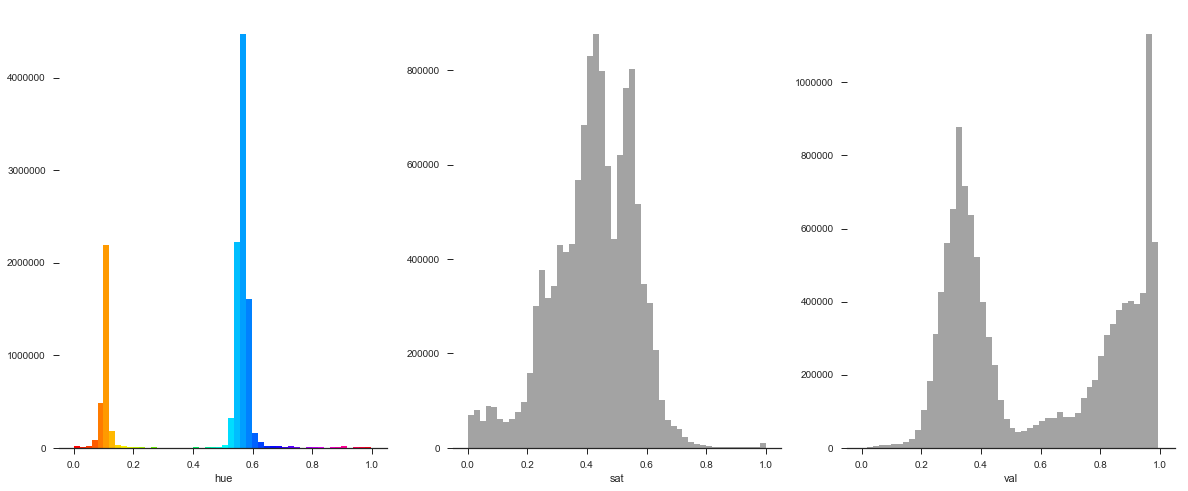

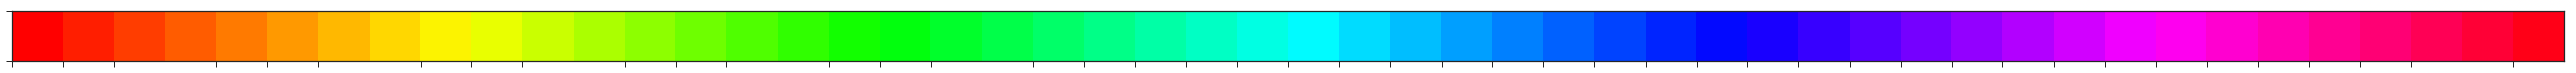

In [20]:
sns.set(style="ticks", color_codes=True)
# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True)
sns.despine(left=True)
# hue
dplot_hue = sns.distplot(df_hsv["hue"], color="b", kde=False, ax=axes[0])
p_num = len(dplot_hue.patches)
cmap_hsv = plt.get_cmap("hsv", 50)
hsv_array = cmap_hsv(range(p_num))
for ind, p in enumerate(dplot_hue.patches):
    p.set_facecolor(hsv_array[ind])
    p.set_alpha(1.0)

# sat
dplot_hue = sns.distplot(df_hsv["sat"], color="k", kde=False, ax=axes[1])

# val
dplot_val = sns.distplot(df_hsv["val"], color="k", kde=False, ax=axes[2])

sns.palplot(hsv_array)

Based on the histogram of the hue, threshold the hue such that only the yellowish colors remain.

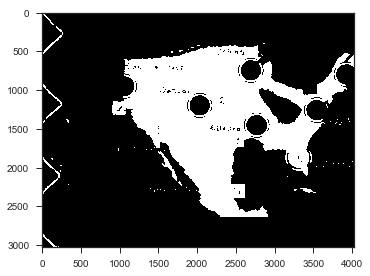

In [13]:
im2 = im_hsv[:,:,0]
im2 = im2 < 0.3
skimage.io.imshow(im2)

Add the cities back using a hough transform.

In [73]:
im_s = im_hsv[:,:,1]
im_s = skimage.morphology.erosion(im_s, skimage.morphology.selem.disk(11))
im_edge = skimage.filters.sobel(im_s)
thresh = skimage.filters.threshold_otsu(im_edge)
im_edge = im_edge > thresh
contours = skimage.measure.find_contours(skimage.img_as_float(im_edge), 0.99)

C:\Users\karhohs\AppData\Local\Continuum\Miniconda3\envs\bioimg\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


TypeError: 'int' object is not iterable

In [84]:
im_contour = skimage.img_as_uint(np.zeros_like(im_s))
for ind, obj in enumerate(contours):
    for xy in obj:
        im_contour[xy[0].astype(int), xy[1].astype(int)] = ind + 1

In [92]:
props = skimage.measure.regionprops(im_contour)

In [103]:
contour_props = {}
contour_props["area"] = [p["area"] for p in props]
contour_props["eccentricity"] = [p["eccentricity"] for p in props]
df_contour = pandas.DataFrame.from_dict(contour_props)

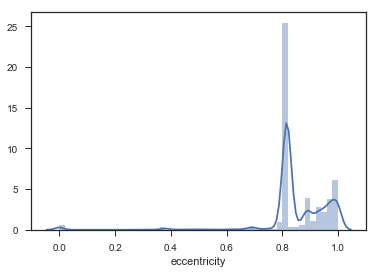

In [105]:
sns.distplot(df_contour["eccentricity"])

In [131]:
df_circular = df_contour.loc[(df_contour["area"] > 1000)]
candidate_circles = df_circular.index.tolist()
candidate_contours = [contours[i] for i in candidate_circles]

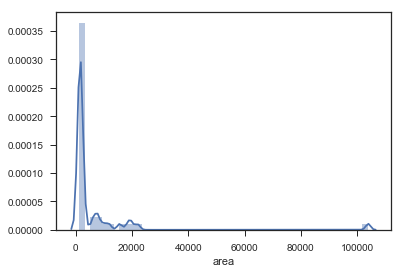

In [132]:
sns.distplot(df_circular["area"])

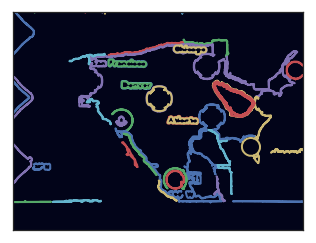

In [133]:
fig, ax = plt.subplots()
ax.imshow(np.zeros_like(im_s))

for n, contour in enumerate(candidate_contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.axis()
plt.show()

In [17]:
im_gray = skimage.color.rgb2gray(im)
im_gray_small = skimage.transform.rescale(im2,0.125)
im_edge = skimage.filters.prewitt(im_gray_small)
im_edge = skimage.morphology.dilation(im_edge)
hough_radii = np.arange(15, 40, 10)
hough_res = skimage.transform.hough_circle(im_gray_small, 20)
accums, cx, cy, radii = skimage.transform.hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)

/Users/Kyle/miniconda3/envs/bioimgmin/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [18]:
radii

array([15, 15, 15])

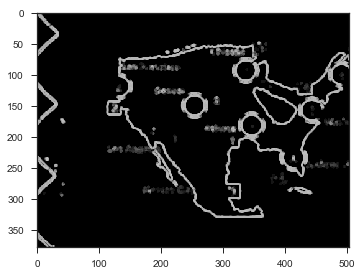

In [19]:
skimage.io.imshow(im_edge)

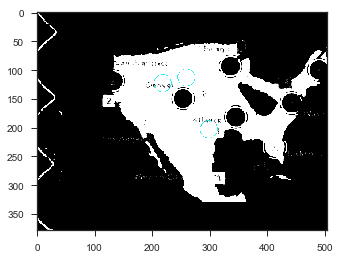

In [20]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = skimage.color.gray2rgb(im_gray_small)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = skimage.draw.circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image)
plt.show()

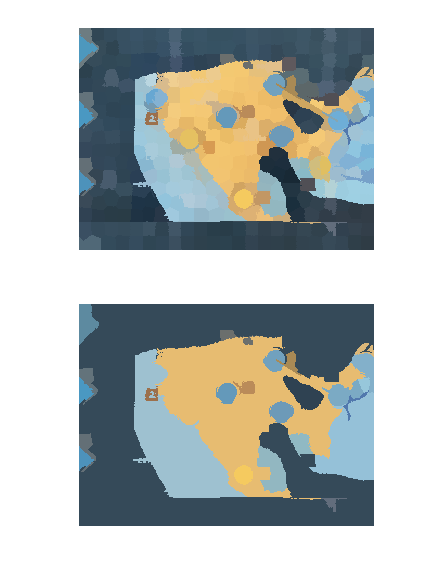

In [6]:
img = im

labels1 = skimage.segmentation.slic(img, compactness=30, n_segments=400)
out1 = skimage.color.label2rgb(labels1, img, kind='avg')

g = skimage.future.graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = skimage.future.graph.cut_normalized(labels1, g)
out2 = skimage.color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

In [15]:
segments = skimage.segmentation.felzenszwalb(im, scale=500.0, sigma=3.0, min_size=5)

C:\Users\karhohs\AppData\Local\Continuum\Miniconda3\envs\bioimg\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


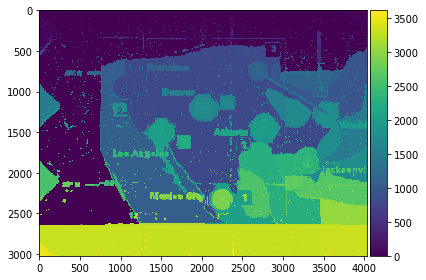

In [16]:
skimage.io.imshow(segments)

In [20]:
segments = skimage.segmentation.active_contour(im)

TypeError: active_contour() missing 1 required positional argument: 'snake'